# Automatic program Repair (APR)

In [1]:

import sys

import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
from data_loader.loader import load_buggy_dataset, load_data, save_data
from bug_detective.detective import process_prompt_dataset
from utils.visualization import compare_groundtruth_vs_corrected_histograms, compare_metrics_versus_bug_histograms, plot_column_distribution, plot_metrics_boxplots
from utils.simple_metrics import compute_and_store_metrics

# Add the data_loader module to the path

# Import data loader functions

# Load sample train data
# print("Loading sample train data...")

# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')


In [3]:
sample_data = load_data("choice_data.pkl")
print("Number of rows: ", len(sample_data))
print("LLM Responses: ", [column for column in sample_data.columns if "response" in column])

Number of rows:  100
LLM Responses:  ['response_qwen-2.5-coder-32b-instruct', 'response_gpt-4o-mini', 'response_gemini-2.0-flash-001', 'response_gemini-2.5-flash', 'response_codestral-2501', 'response_gpt-4.1']


In [4]:
sample_data.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,...,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,response_qwen-2.5-coder-32b-instruct,response_gpt-4o-mini,response_gemini-2.0-flash-001,response_gemini-2.5-flash,response_codestral-2501,response_gpt-4.1
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak/backends/bluezdbus/client.py,# -*- coding: utf-8 -*-\nimport logging\nimpor...,# -*- coding: utf-8 -*-\nimport logging\nimpor...,BleakClientBlueZDBus.stop_notify,https://github.com/hbldh/bleak/issues/55,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/hom...",bleak.exc.BleakError,...,[],[],buggy_snippets_files/d534f47d51c12cba5c48476b2...,buggy_snippets_files/d534f47d51c12cba5c48476b2...,"async def stop_notify(self, _uuid: str) -> Non...","async def stop_notify(self, _uuid: str) -> Non...","async def stop_notify(self, _uuid: str) -> Non...","async def stop_notify(self, _uuid: str) -> Non...","async def stop_notify(self, _uuid: str) -> Non...","async def stop_notify(self, _uuid: str) -> Non..."
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",tqdm/std.py,"""""""\nCustomisable progressbar decorator for it...","""""""\nCustomisable progressbar decorator for it...",inner_generator.inner,https://github.com/tqdm/tqdm/issues/862,"[{'piece_type': 'source code', 'piece_content'...",----------------------------------------------...,TypeError,...,[],[],buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,"def inner(df, func, *args, **kwargs):\n tot...","def inner(df, func, *args, **kwargs):\n tot...","def inner(df, func, *args, **kwargs):\n ...","def inner(df, func, *args, **kwargs):\n ...","def inner(df, func, *args, **kwargs):\n\n t...","def inner(df, func, *args, **kwargs):\n tot..."
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram/utils/request.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Request.post,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'other', 'piece_content': 'fro...","Traceback (most recent call last):\nFile ""/tmp...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,...,[],[],buggy_snippets_files/6c268a7167cd7c7691093e131...,buggy_snippets_files/6c268a7167cd7c7691093e131...,"def post(self, url, data, timeout=None):\n ...","def post(self, url, data, timeout=None):\n ...","def post(self, url, data, timeout=None):\n ...","def post(self, url, data, timeout=None):\n ...","def post(self, url, data, timeout=None):\n\n ...","def post(self, url, data, timeout=None):\n ..."
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,examples/demo/gloo/realtime_signals.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,Canvas.__init__,https://github.com/vispy/vispy/issues/528,"[{'piece_type': 'error message', 'piece_conten...",cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...,IndexError,...,[],[],buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,def __init__(self):\n app.Canvas.__init__(s...,self.program['a_position'] = y.ravel().reshape...,def __init__(self):\n app.Canvas.__init...,def __init__(self):\n app.Canvas.__init...,def __init__(self):\n app.Canvas.__init__(s...,"self.program['a_position'] = y.reshape(-1, 2)"
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",hub/collections/dataset/core.py,from collections import abc\nfrom configparser...,from collections import abc\nfrom configparser...,load,https://github.com/activeloopai/Hub/issues/216,"[{'pi

In [5]:

prompt_data = buggy_train_df.sample(n=100, random_state=0)
# sample_data = load_data("data_20250703_235942.pkl")
print(f"Sample data shape: {prompt_data.shape}")
print(f"Sample data columns: {prompt_data.columns.tolist()}")


Sample data shape: (100, 16)
Sample data columns: ['after_merge', 'before_merge', 'filename', 'full_file_code_after_merge', 'full_file_code_before_merge', 'function_name', 'url', 'source code and errors', 'full_traceback', 'traceback_type', 'before_merge_without_docstrings', 'after_merge_without_docstrings', 'before_merge_docstrings', 'after_merge_docstrings', 'path_to_snippet_before_merge', 'path_to_snippet_after_merge']


In [6]:
important_columns = ["before_merge_without_docstrings", "after_merge_without_docstrings", "traceback_type","full_traceback"]
prompt_data = prompt_data.loc[:, [col for col in important_columns if col in prompt_data.columns]]
prompt_data.head()

,before_merge_without_docstrings,after_merge_without_docstrings,traceback_type,full_traceback
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak.exc.BleakError,"Traceback (most recent call last):\nFile ""/hom..."
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",TypeError,----------------------------------------------...
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,"Traceback (most recent call last):\nFile ""/tmp..."
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,IndexError,cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",ValueError,"Traceback (most recent call last):\nFile ""hub/..."


In [ ]:
instruction_prompt = "You are a helpful assistant that corrects the code based on the traceback error. You must respect the original code structure and the original code style"

4 - fechada pequena, aberta pequena focada em code

In [8]:
from llm_models.open_router import create_openrouter_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct",
    temperature=0.0,
    max_tokens=1000
)
gpt_4o_mini_model = create_openrouter_model(
    model_name="openai/gpt-4o-mini",
    temperature=0.0,
    max_tokens=1000
)

gemini_2_5_flash_model = create_openrouter_model(
    model_name="google/gemini-2.5-flash",
    temperature=0.0,
    max_tokens=1000
)

codestral_model = create_openrouter_model(
    model_name="mistralai/codestral-2501",
    temperature=0.0,
    max_tokens=1000
)
gpt_4_1_model = create_openrouter_model(
    model_name="openai/gpt-4.1",
    temperature=0.0,
    max_tokens=1000
)






In [14]:
print(type(prompt_data))
if not isinstance(prompt_data, pd.DataFrame):
    prompt_data = pd.DataFrame(prompt_data)
print(type(prompt_data))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [15]:
import pandas as pd

# Ensure prompt_data is a DataFrame
# if not isinstance(prompt_data, pd.DataFrame):
    # prompt_data = pd.DataFrame(prompt_data)

outputs_qwen = await process_prompt_dataset(qwen_model, prompt_data)
prompt_data['response_qwen-2.5-coder-32b-instruct'] = outputs_qwen

outputs_gpt_4o_mini = await process_prompt_dataset(gpt_4o_mini_model, prompt_data)
prompt_data['response_gpt-4o-mini'] = outputs_gpt_4o_mini

outputs_gemini_2_5_flash = await process_prompt_dataset(gemini_2_5_flash_model, prompt_data)
prompt_data['response_gemini-2.5-flash'] = outputs_gemini_2_5_flash

outputs_codestral = await process_prompt_dataset(codestral_model, prompt_data)
prompt_data['response_codestral-2501'] = outputs_codestral

outputs_gpt_4_1 = await process_prompt_dataset(gpt_4_1_model, prompt_data)
prompt_data['response_gpt-4.1'] = outputs_gpt_4_1



Processing sample 3/100:   2%|▋                                | 2/100 [00:16<13:33,  8.30s/samples]


CancelledError: 

### Save data

In [ ]:
# import pickle
# import pandas as pd
# from datetime import datetime
# from pathlib import Path
# import os

# data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints'

# # Get number of rows
# num_rows = len(sample_data)

# # Get all response columns
# response_columns = [col for col in sample_data.columns if "response_" in col]
# response_names = "_".join([col.replace("response_", "") for col in response_columns])

# # Compose file name
# file_name = f"sample_data_{num_rows}_rows_{response_names}.pkl"
# file_path = os.path.join(data_path, file_name)

# Path(data_path).mkdir(parents=True, exist_ok=True)
# with open(file_path, 'wb') as f:
#     pickle.dump(sample_data, f)
# print(f"Data saved to: {file_path}")


### Load Data

In [ ]:
# save_data(sample_data,"100_metrics.pkl")

Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/100_metrics.pkl


'/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/100_metrics.pkl'

In [ ]:

sample_data.columns

Creating boxplots using stored metrics for 6 response columns...


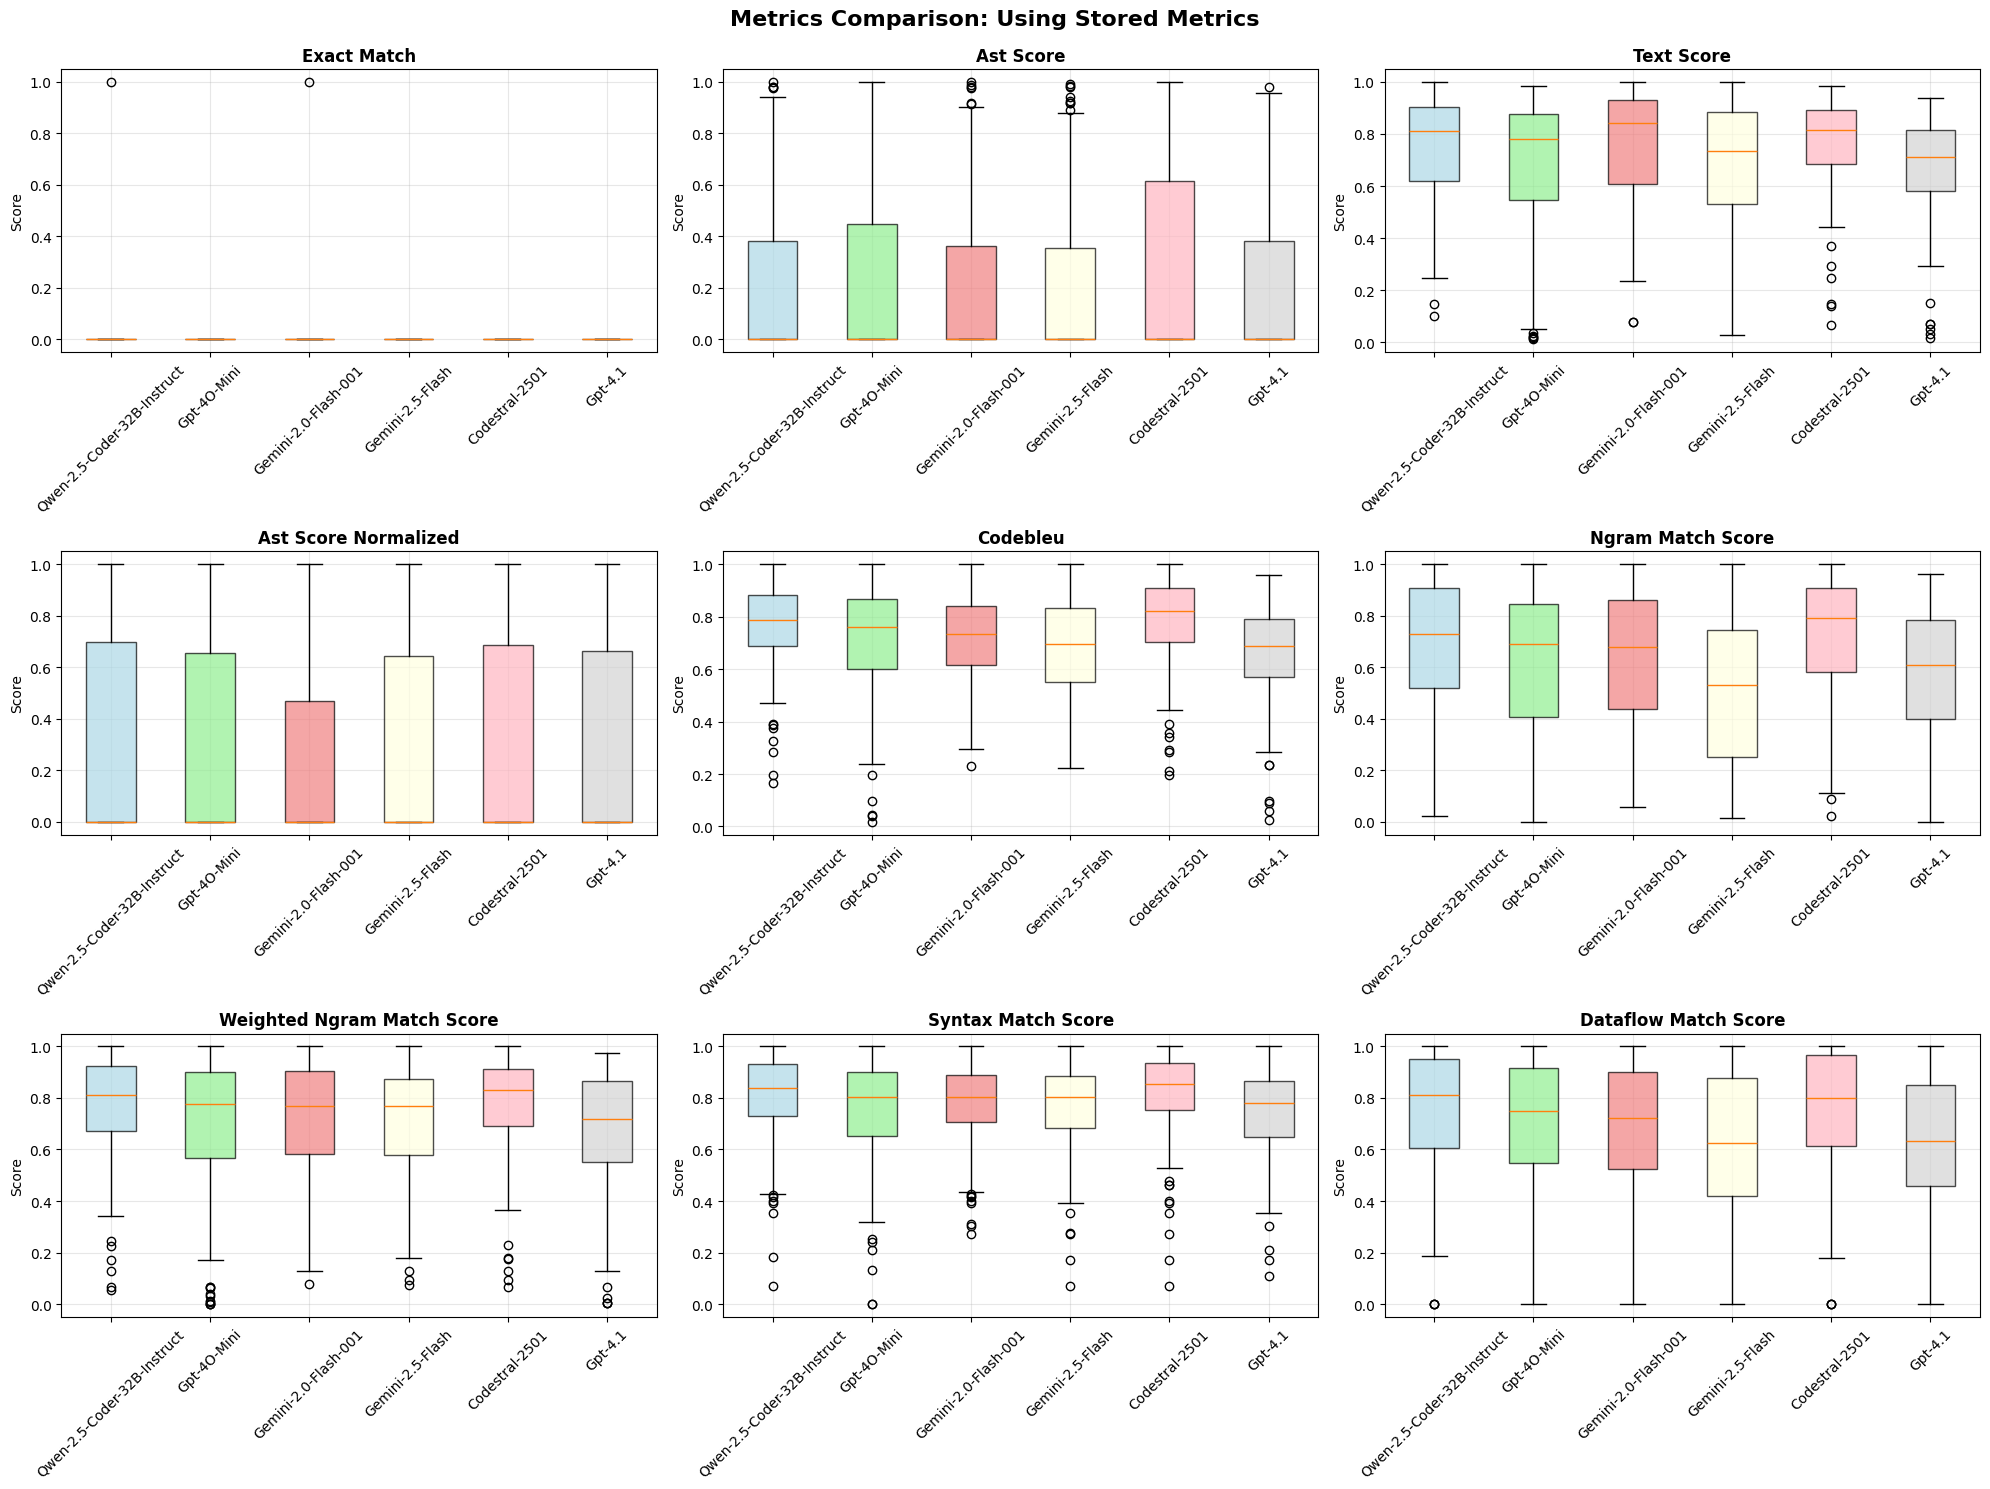


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 6
Number of metrics: 9
Available metrics: ['exact_match', 'ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Exact Match:
  Qwen-2.5-Coder-32B-Instruct: mean=0.010, std=0.100, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.000, std=0.000, median=0.000 (n=100)
  Gemini-2.0-Flash-001: mean=0.010, std=0.100, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.000, std=0.000, median=0.000 (n=100)
  Codestral-2501: mean=0.000, std=0.000, median=0.000 (n=100)
  Gpt-4.1: mean=0.000, std=0.000, median=0.000 (n=100)

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.215, std=0.364, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.221, std=0.363, median=0.000 (n=100)
  Gemini-2.0-Flash-001: mean=0.180, std=0.319, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.189, std=0.334, median=0.000 (n=100)
  Codestral-2501: mean=0.246,

In [4]:
plot_metrics_boxplots(sample_data, reference_column="after_merge_without_docstrings")

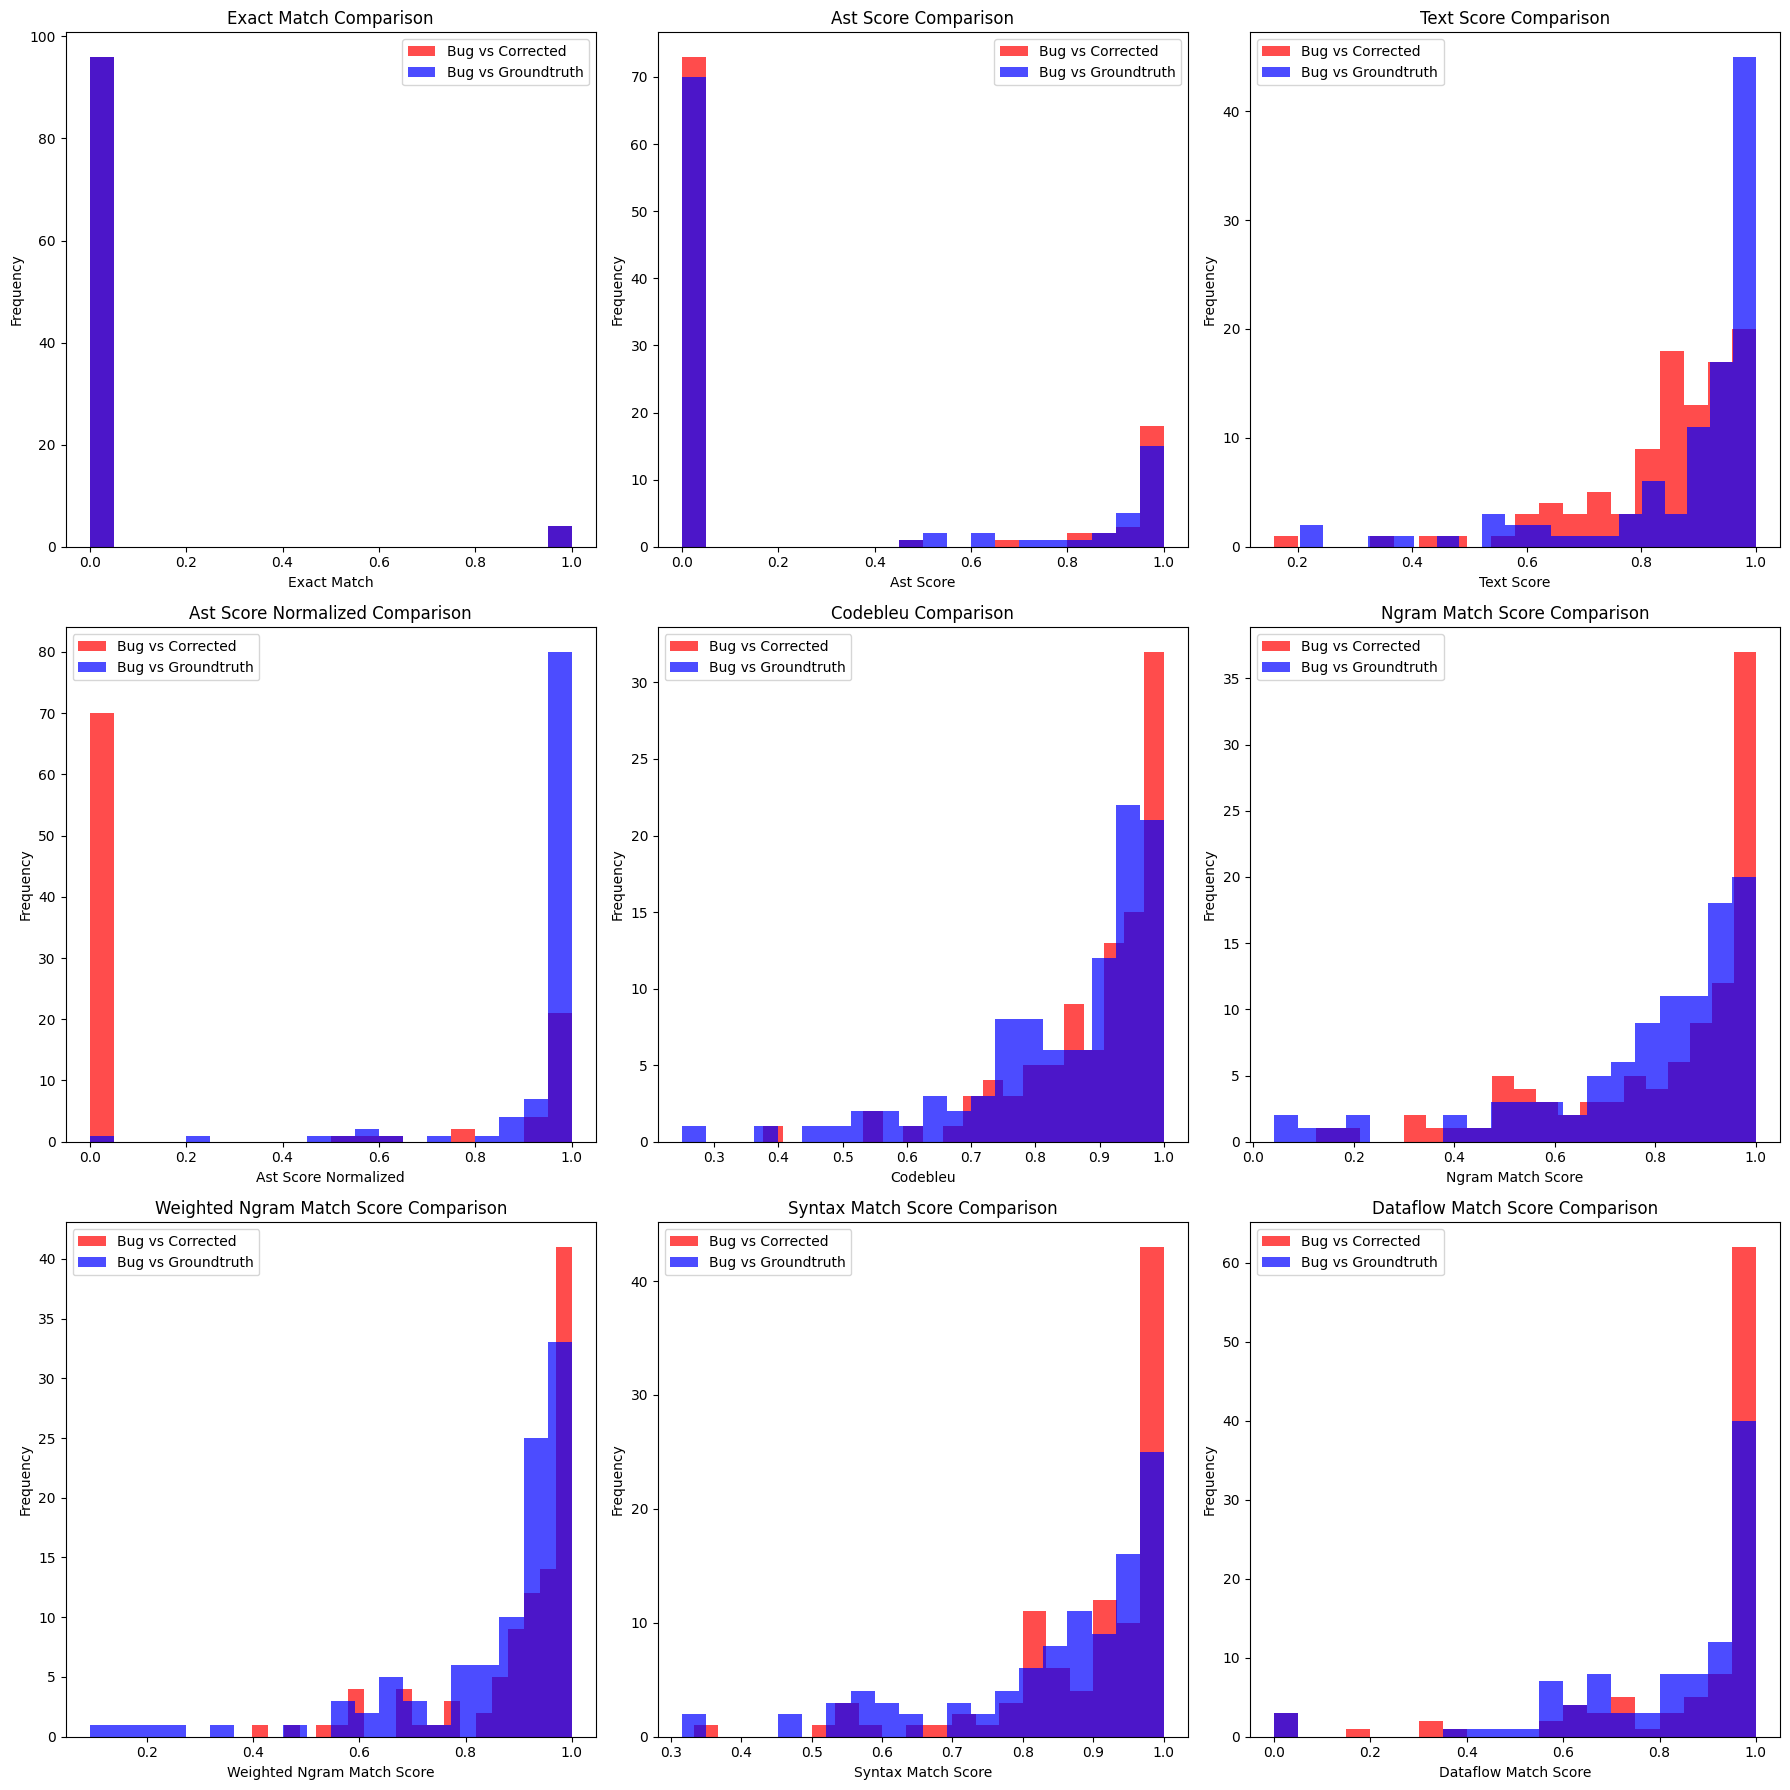

=== ALL METRICS STATISTICS ===
Exact Match - Bug vs Corrected: mean=0.040, std=0.196
Exact Match - Bug vs Groundtruth: mean=0.040, std=0.196
Ast Score - Bug vs Corrected: mean=0.251, std=0.417
Ast Score - Bug vs Groundtruth: mean=0.262, std=0.410
Text Score - Bug vs Corrected: mean=0.845, std=0.149
Text Score - Bug vs Groundtruth: mean=0.879, std=0.174
Ast Score Normalized - Bug vs Corrected: mean=0.278, std=0.431
Ast Score Normalized - Bug vs Groundtruth: mean=0.944, std=0.157
Codebleu - Bug vs Corrected: mean=0.893, std=0.116
Codebleu - Bug vs Groundtruth: mean=0.847, std=0.150
Ngram Match Score - Bug vs Corrected: mean=0.817, std=0.206
Ngram Match Score - Bug vs Groundtruth: mean=0.785, std=0.221
Weighted Ngram Match Score - Bug vs Corrected: mean=0.901, std=0.135
Weighted Ngram Match Score - Bug vs Groundtruth: mean=0.852, std=0.191
Syntax Match Score - Bug vs Corrected: mean=0.898, std=0.131
Syntax Match Score - Bug vs Groundtruth: mean=0.847, std=0.160
Dataflow Match Score - Bug 

In [5]:
compare_metrics_versus_bug_histograms(sample_data['before_merge_without_docstrings'],sample_data['after_merge_without_docstrings'],sample_data['response_qwen-2.5-coder-32b-instruct'])

In [ ]:
compare_metrics_versus_bug_histograms(sample_data['before_merge'],sample_data['after_merge'],sample_data['response_gpt-4o-mini'])

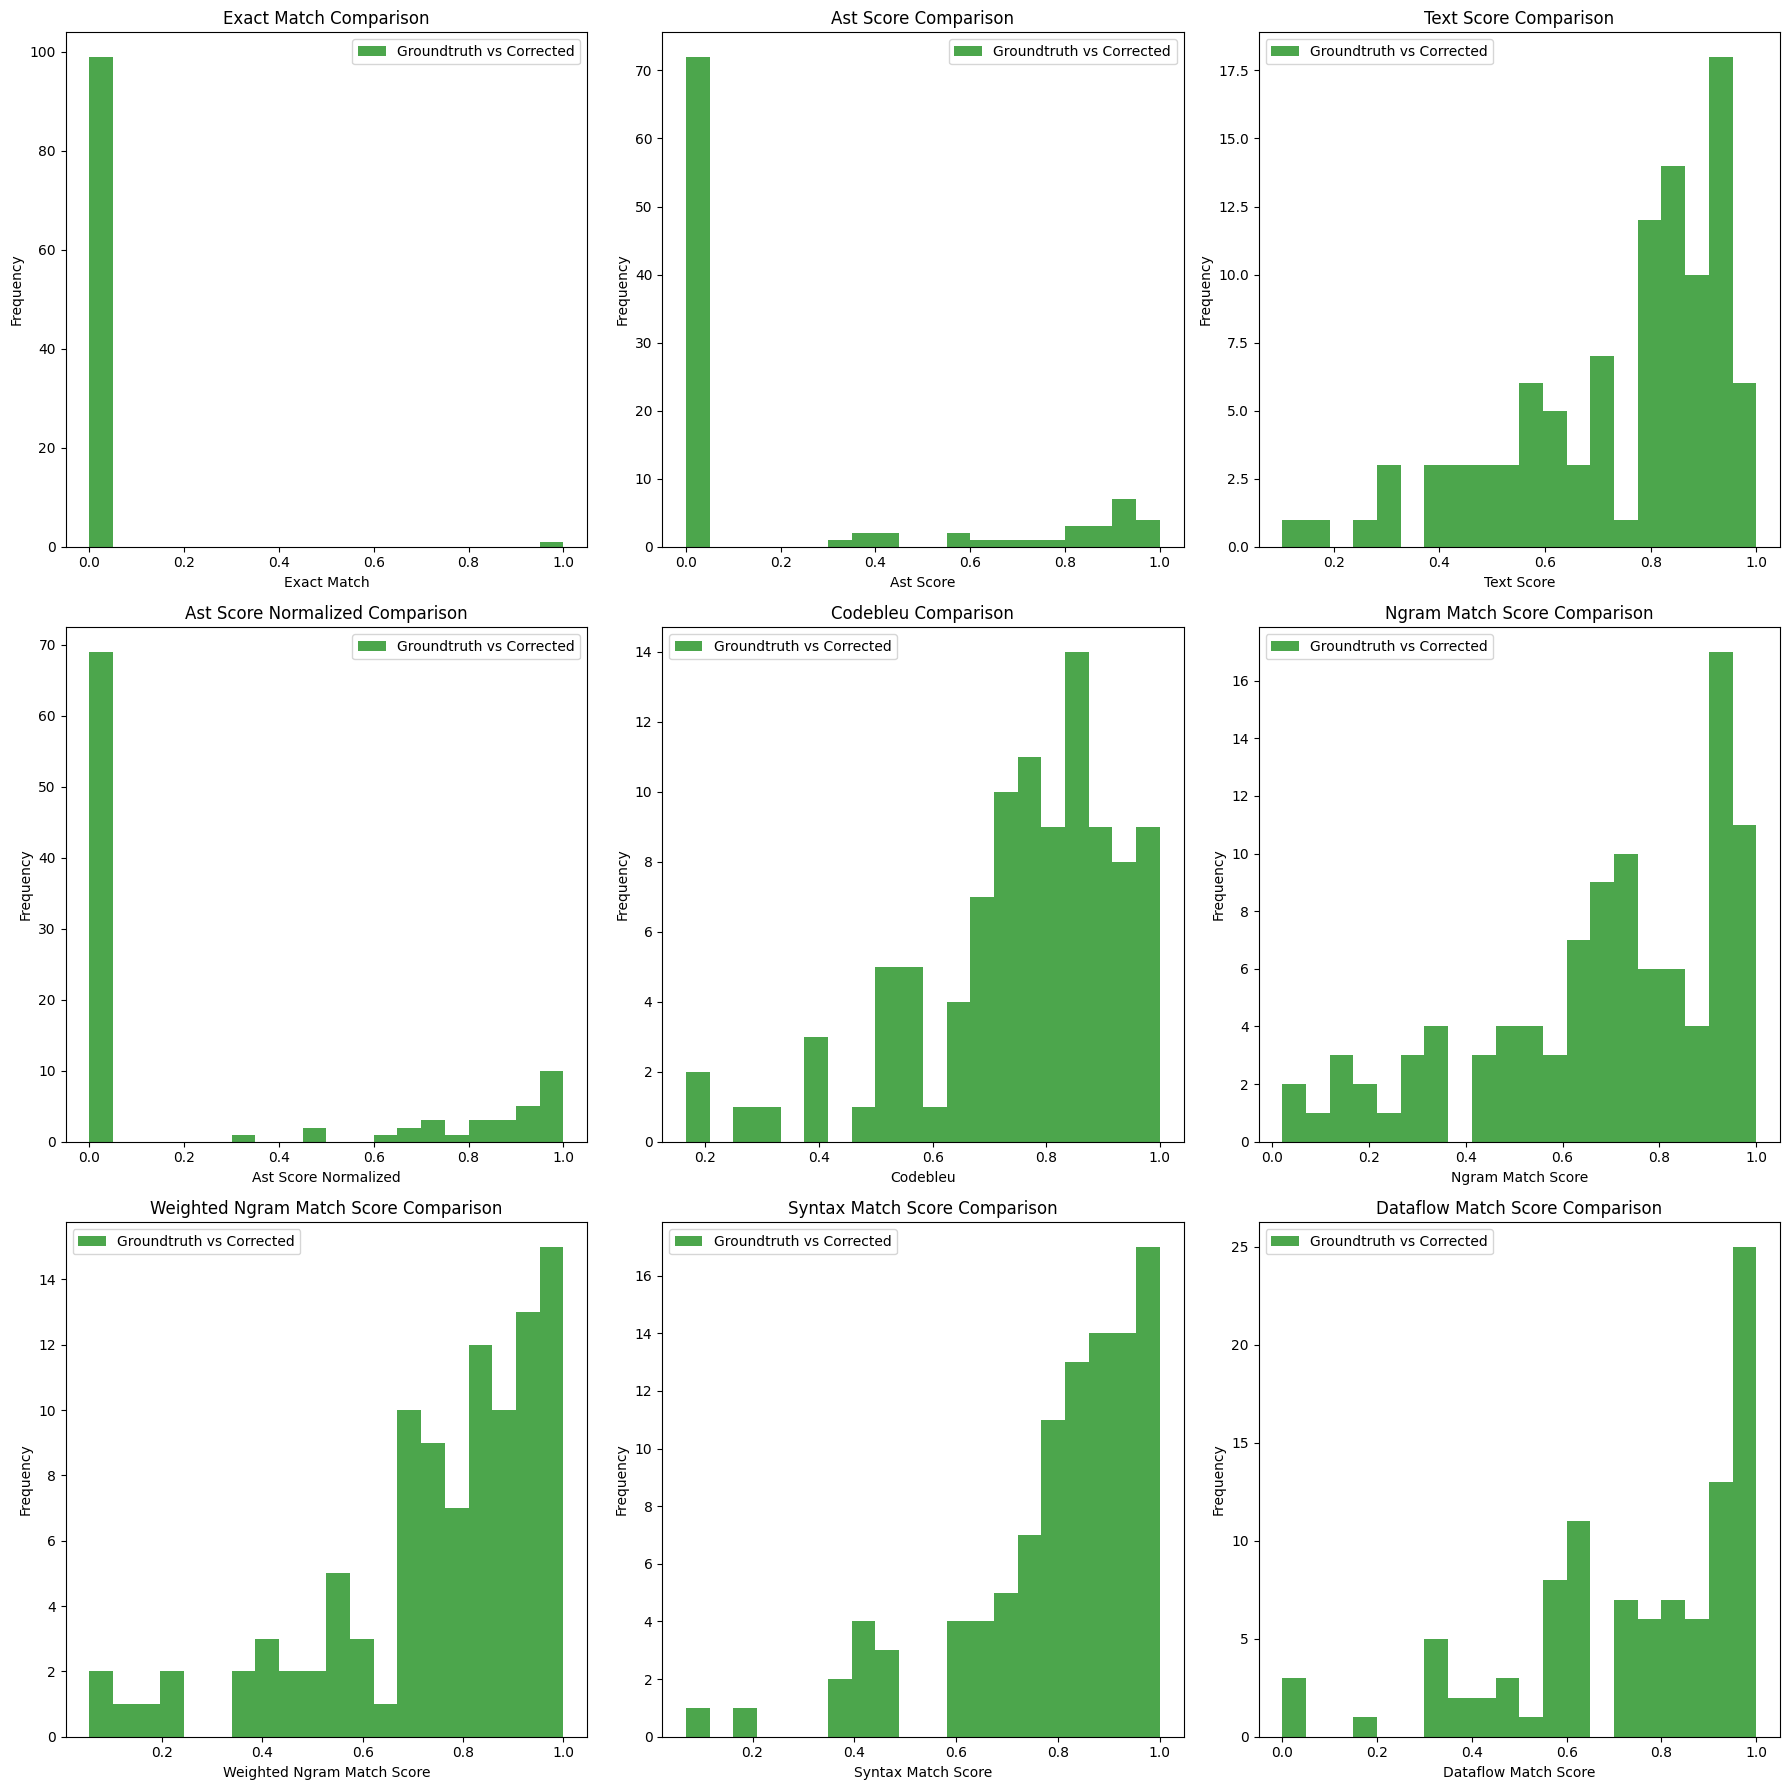

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.010, std=0.099
Ast Score - Groundtruth vs Corrected: mean=0.215, std=0.363
Text Score - Groundtruth vs Corrected: mean=0.743, std=0.205
Ast Score Normalized - Groundtruth vs Corrected: mean=0.259, std=0.398
Codebleu - Groundtruth vs Corrected: mean=0.756, std=0.180
Ngram Match Score - Groundtruth vs Corrected: mean=0.682, std=0.256
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.749, std=0.224
Syntax Match Score - Groundtruth vs Corrected: mean=0.796, std=0.187
Dataflow Match Score - Groundtruth vs Corrected: mean=0.743, std=0.246


In [6]:
compare_groundtruth_vs_corrected_histograms(sample_data['after_merge_without_docstrings'],sample_data['response_qwen-2.5-coder-32b-instruct'])

#### qwen 
Exact Match - Groundtruth vs Corrected: mean=0.010, std=0.099
Ast Score - Groundtruth vs Corrected: mean=0.201, std=0.346
Text Score - Groundtruth vs Corrected: mean=0.734, std=0.208
Ast Score Normalized - Groundtruth vs Corrected: mean=0.237, std=0.382
Codebleu - Groundtruth vs Corrected: mean=0.733, std=0.197
Ngram Match Score - Groundtruth vs Corrected: mean=0.644, std=0.298
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.706, std=0.258
Syntax Match Score - Groundtruth vs Corrected: mean=0.783, std=0.189
Dataflow Match Score - Groundtruth vs Corrected: mean=0.739, std=0.257

#### gpt
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.200, std=0.347
Text Score - Groundtruth vs Corrected: mean=0.652, std=0.274
Ast Score Normalized - Groundtruth vs Corrected: mean=0.253, std=0.390
Codebleu - Groundtruth vs Corrected: mean=0.662, std=0.226
Ngram Match Score - Groundtruth vs Corrected: mean=0.547, std=0.322
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.623, std=0.308
Syntax Match Score - Groundtruth vs Corrected: mean=0.740, std=0.230
Dataflow Match Score - Groundtruth vs Corrected: mean=0.660, std=0.290


Boxplot pra cada modelo vs gt lado a lado
adicionar modelos de tamanho similares.

sera que se eu pedir (mudança de prompt) para ele fixar o estilo ele perde a corretude no bug

add mais 2 modelos (pequeno e medio)


In [ ]:
compare_groundtruth_vs_corrected_histograms(sample_data['after_merge_without_docstrings'],sample_data['response_gpt-4o-mini'])

In [ ]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'AttributeError']['after_merge'],sample_data[sample_data['traceback_type'] == 'AttributeError']['response_gpt-4o-mini'])

In [ ]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'ValueError']['after_merge'],sample_data[sample_data['traceback_type'] == 'ValueError']['response_gpt-4o-mini'])

In [ ]:
# Call the function with the lists
compare_metrics_versus_bug_histograms(sample_data['before_merge'],sample_data['after_merge'],sample_data['response_qwen-2.5-coder-32b-instruct'])

In [ ]:
from utils.simple_metrics import codebleu
codebleu_scores = codebleu(sample_data['before_merge'].iloc[0], sample_data['after_merge'].iloc[0])
print(codebleu_scores)

In [ ]:
codebleu_scores = codebleu(sample_data['before_merge_without_docstrings'].iloc[0], sample_data['after_merge_without_docstrings'].iloc[0])
print(codebleu_scores)

In [ ]:
print(sample_data['response_gpt-4o-mini'].iloc[0])